## Experiments can be found at the bottom of this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import itertools
from itertools import combinations
import pydot
import warnings
import scipy
import scipy.stats as ss
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Helper functions

In [2]:
import matplotlib
matplotlib.rcParams['axes.formatter.useoffset'] = False
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
FONTSIZE = 12.5
COLORS = itertools.cycle(["#a80000", "#00a8a8", "#5400a8", "#54a800",
                          '#dc00dc', '#dc6e00', '#00dc00', '#006edc'])
MARKERS = itertools.cycle(['.', '+', 'o', '*', 'v', '>', '<', 'd'])
plt.rcParams["mathtext.fontset"] = "cm"


# helper functions
def plot_conf_bounds(ms, stds, ns, confidence_level= 0.95):
    margin_err = zscore(confidence_level=confidence_level) * np.array(stds) / np.sqrt(np.array(ns))
    plt.fill_between(np.arange(1, len(ms)+1), np.array(ms) - margin_err,
                            np.array(ms) + margin_err,
                         alpha=0.2)
    
def plot_mean(ms, label):
    plt.plot(np.arange(1, len(ms)+1), ms, label=label)
    
def update_agg_log(agg_log, log):
    for idx, datum in enumerate(log):
        if idx >= len(agg_log):
            agg_log.append([datum])
        else:
            agg_log[idx].append(datum)
        
def mean_agg_log(agg_log):
    res = [np.mean(_) for _ in agg_log]
    return res
    
def std_agg_log(agg_log):
    res = [np.std(_) for _ in agg_log]
    return res

def zscore(confidence_level=0.95):
    """
    return the zscore
    """
    return scipy.stats.norm.ppf((1+confidence_level)/2)


def plot_df_trace(m_maur_df, m_sign_df, m_elim_df, m_gray_df, 
                  s_maur_df, s_sign_df, s_elim_df, s_gray_df, 
                  n_maur_df, n_sign_df, n_elim_df, n_gray_df, 
                  is_exact, label_suffix):
    """
    Plot the trace of the Hammming distance of the oracles made by the algorithms
    maurer, signhunter, elimination, and goo
    """
    plt.clf()
    plot_mean(m_maur_df, label=r'''\texttt{Maurer's}''')
    plot_mean(m_sign_df, label=r'''\texttt{SignHunter}''')
    plot_mean(m_elim_df, label=r'''\texttt{Elimination}''')
    plot_mean(m_gray_df, label=r'''\texttt{GOO}''')
    plot_conf_bounds(m_maur_df, s_maur_df, n_maur_df)
    plot_conf_bounds(m_sign_df, s_sign_df, n_sign_df)
    plot_conf_bounds(m_elim_df, s_elim_df, n_elim_df)
    plot_conf_bounds(m_gray_df, s_gray_df, n_gray_df)
    plt.ylabel(r"""\bf{Directional Derivative} ($D_\mathbf{q}f(\mathbf{x})$)""")
    plt.xlabel(r"""\bf{\# queries}""")
    plt.legend()
    #x_min, x_max = plt.xlim()
    #plt.xticks(np.arange(1, int(x_max + 1)))
    plt.minorticks_on()
    plt.savefig("%s_hd_df_%s.pdf" % ("exact" if is_exact else "approx", label_suffix))
    
def plot_hd_trace(m_maur_ham, m_sign_ham, m_elim_ham, m_gray_ham, 
                  s_maur_ham, s_sign_ham, s_elim_ham, s_gray_ham, 
                  n_maur_ham, n_sign_ham, n_elim_ham, n_gray_ham, 
                  is_exact, label_suffix):
    """
    Plot the trace of the Hammming distance of the oracles made by the algorithms
    maurer, signhunter, elimination, and goo
    """
    plt.clf()
    plot_mean(m_maur_ham, label=r'''\bf{\texttt{Maurer's}}''')
    plot_mean(m_sign_ham, label=r'''\bf{\texttt{SignHunter}}''')
    plot_mean(m_elim_ham, label=r'''\bf{\texttt{Elimination}}''')
    plot_mean(m_gray_ham, label=r'\bf{\texttt{GOO}}''')
    plot_conf_bounds(m_maur_ham, s_maur_ham, n_maur_ham)
    plot_conf_bounds(m_sign_ham, s_sign_ham, n_sign_ham)
    plot_conf_bounds(m_elim_ham, s_elim_ham, n_elim_ham)
    plot_conf_bounds(m_gray_ham, s_gray_ham, n_gray_ham)
    plt.ylabel(r"\bf{Hamming Distance ($||\mathbf{q} - \mathbf{s}^* ||_H$)}")
    plt.xlabel(r"\bf{\# queries}")
    plt.legend()
    #x_min, x_max = plt.xlim()
    plt.minorticks_on()
    #plt.xticks(np.arange(1, int(x_max + 1)))
    plt.savefig("%s_hd_hd_%s.pdf" % ("exact" if is_exact else "approx", label_suffix))
    
def hamming_dist(a, b):
    return sum([ np.sign(_a) != np.sign(_b) for _a, _b in zip(a, b)])

def str_hamming_dist(a, b, is_dot=False):
    assert len(a) == len(b), "len(a):{}, len(b):{}".format(len(a),len(b))
    if is_dot:
        x = np.array(map(lambda _x: 1 if _x == '1' else -1, a))
        y = np.array(map(lambda _x: 1 if _x == '1' else -1, b))
        return (len(a) - np.dot(x, y)) / 2.
    else:
        return sum([_a != _b for _a, _b in zip(a,b)])

## Hamming Search Algorithms

In [3]:
"""
Python Implementation of the algorithm by

Maurer, P. M. 2009. A search strategy using
a hamming-distance oracle.
"""

class BitVecFinder(object):
    def __init__(self, oracle, n):
        self.oracle = oracle
        self.n = n
        self.found_bit_vec = ['x'] * n
        self._num_queries = 0
        self._queries = []

    def find(self):
        q = [1] * self.n
        self._queries.append(q)
        res = self.oracle(q)
        self._num_queries += 1
        if res == self.n:
            self.found_bit_vec = [-1] * self.n
        elif res == 0:
            self.found_bit_vec =  [1] * self.n
        else:
            self.query(0, self.n // 2, 0, res, self.n)

        self._queries.append(self.found_bit_vec)

    def query(self, pos, q_num_ones, h_ext_ones, h_zeros, q_len):
        q_num_zeros = q_len - q_num_ones
        q = [-1] * self.n
        q[pos: pos+ q_num_ones] = [1] * q_num_ones
        self._queries.append(q)
        res = self.oracle(q) - h_ext_ones
        self._num_queries += 1
        # number of zeros in the first
        z0 = (res + h_zeros - q_num_zeros) / 2
        z1 = h_zeros - z0
        # approx
        z0 = np.clip(np.ceil(z0).astype(int), 0, q_num_ones)
        z1 = np.clip(np.ceil(z1).astype(int), 0, q_num_zeros)
        #print("pos:{}, q_num_ones:{}, h_ext_ones:{}, h_zeros:{}, q_len:{}".format(
        #    pos, q_num_ones, h_ext_ones, h_zeros, q_len))
        #print("z0: {}, z1: {}".format(z0, z1))
        if z0 == 0:
            self.found_bit_vec[pos:pos + q_num_ones] = [1] * q_num_ones
        elif z0 == q_num_ones:
            self.found_bit_vec[pos:pos + q_num_ones] = [-1] * q_num_ones
        else:
            self.query(pos, q_num_ones // 2, h_ext_ones + (q_num_zeros - z1), z0, q_num_ones)

        if z1 == 0:
            self.found_bit_vec[pos + q_num_ones:pos + q_len] = [1] * q_num_zeros
        elif z1 == q_num_zeros:
            self.found_bit_vec[pos + q_num_ones:pos + q_len] = [-1] * q_num_zeros
        else:
                self.query(pos + q_num_ones, q_num_zeros // 2, h_ext_ones + (q_num_ones - z0), z1, q_num_zeros)
        # print(self.found_bit_vec)

    @property
    def bit_vec(self):
        return self.found_bit_vec

    @property
    def num_queries(self):
        return self._num_queries

    @property
    def queries(self):
        return self._queries

In [4]:
# gray code stuff
def get_gray_code(j, n=None, is_array=False):
    """
        returns the jth gray code
        
    :parameter j: the index of the jth parameter
    :parameter n: the number of bits in the code
    """
    code = bin(j ^ (j >> 1))
    code = code[2:] if n is None else code[2:].zfill(n)
    if is_array:
        return np.array(list(map(lambda _x: 1 if _x == '1' else -1, code)))
    else:
        return code



In [5]:
# Node class for the GOO algorithm
class Node(object):
    def __init__(self, i, h):
        self._i = i
        self._h = h
        self._val = None

    def get_seq(self, n):
        """
        Get the rank of the representative code
        """
        return int(2**(n - 1 - self._h ) + self._i * 2 **(n - self._h))
    
    def get_code(self, n, is_array=True):
        """
        Get the representative code
        """
        return get_gray_code(self.get_seq(n), n=n, is_array=is_array)
    
    @property
    def value(self):
        return self._val

    def evaluate(self, fct, n):
        """
        Evaluate the node by fct according to its graycode
        """
        _code = self.get_code(n)
        #print("code: {}".format(_code))
        self._val = fct(_code)
        return self._val
    
    def expand(self, n, expand_one=True):
        """
        Expand the node into its children
        """
        seq = self.get_seq(n)
        if seq == 1 and expand_one:
            return [Node(0, self._h + 1)]
        elif seq % 2 != 0 or seq == 0:
            return []
        else:
            return [Node(2 * self._i, self._h + 1), Node(2 * self._i + 1, self._h + 1)]
    
    @property 
    def idx(self):
        return self._i
    
    @property
    def depth(self):
        return self._h 
        
    def __str__(self):
        return "(i={}, h={}, val={})".format(self._i, self._h, self._val)

In [6]:
def gray_oo(n, max_fevals, fct, is_dot_file=False):
    """
    Gray Code-Based Optimistic Optimization
    """
    # set depth 
    depth = -1
    min_depth = 0
    rchd_depth = 0
    num_fevals = 0
    depth_step = 2.0 * np.sqrt(n)
    max_depth = depth_step
    # graph for visualization purposes
    if is_dot_file:
        graph = pydot.Dot(graph_type='graph')
    v_min = float("inf")
    tree = [Node(0,0)]
    tree[0].evaluate(fct, n)
    best_value = tree[0].value
    best_node = tree[0]
    num_fevals += 1
    while num_fevals < max_fevals:
        if len(tree) == 0:
            print("Tree is exhausted, exiting!")
            break
        depth += 1
        #print("current depth: {}".format(depth))
        if depth >= max_depth:
            # go to the lowest depth among leaf nodes
            depth = min_depth
            v_min = float("inf")
        # get nodes at depth and their indices
        cur_ids = [idx for idx, node in enumerate(tree) if node.depth == depth]
        # to break ties arbitrarliy if cur_nodes have the same value ()
        # this happens in the case of the exact hamming distance
        np.random.shuffle(cur_ids) 
        cur_nodes = [tree[idx] for idx in cur_ids]
        if len(cur_nodes) == 0:
            # if depth is exahusted, reset
            if depth > rchd_depth:
                depth = min_depth - 1
                v_min = float("inf")
                #print("reset to top of tree, depth is exhausted")
                #print("min depth {}| max_depth {}| rch depth {}|".format(min_depth, max_depth, rchd_depth))
            continue
        #print(cur_nodes)
        cur_node_idx = np.argmin([node.value for node in cur_nodes])
        cur_node = cur_nodes[cur_node_idx]
        # test for expansion
        if cur_node.value > v_min:
            # go to the tip of the tree
            depth = min_depth - 1
            v_min = float("inf")
            #print("continue: cur node value is not enough to expand")
            continue
        else:
            v_min = cur_node.value

        # some book keeping to grow the depth as we exhaust the current possible nodes
        if len(cur_nodes) == 1:
            #print("min depth updated to {}!".format(min_depth))
            if cur_nodes[0].depth == min_depth:
                min_depth += 1
                max_depth = min_depth + depth_step
        del tree[cur_ids[cur_node_idx]]
        #print("expanding cur node: {}, with seq: {}".format(cur_node, cur_node.get_seq(n)))
        new_nodes = cur_node.expand(n)
        for _node in new_nodes:
            if best_value > _node.evaluate(fct, n):
                best_node = _node
                best_value = _node.value
            #print(_node)
            _u = str(cur_node.get_code(n, is_array=False))
            _v = str(_node.get_code(n, is_array=False))
            _u = str("({},{})".format(cur_node.depth, cur_node.idx))
            _v = str("({},{})".format(_node.depth, _node.idx))
            #print("add edge {}->{}".format(_u, _v))
            if is_dot_file:
                graph.add_edge(pydot.Edge(_u, _v))
        tree += new_nodes
        # update the rchd_depth
        rchd_depth = max(rchd_depth, depth + 1)
        num_fevals += len(new_nodes)
    if is_dot_file:
        graph.write_png('goo_graph.png')   
    #print(best_value, n, float(num_fevals) / n)
    #print("best_value, n)
    return best_value, best_node.get_code(n),  num_fevals

In [7]:
class ORACLE(object):
    """
    A wrapper around the `df_hamming_oracle` fct which seeks to approximate the hamming distance
    such that it satisfies the triangular inequality
    """
    def __init__(self, df_hamming_oracle):
        self.oracle_fct = df_hamming_oracle
        self.vs = []
        self.os = []
        
    def oracle(self, v):
        oi = self.oracle_fct(v)
        #print("before oi: {}".format(oi))
        for os_u, u in zip(self.os, self.vs):
            mij = hamming_dist(u, v)
            oi = np.clip(oi, os_u - mij, os_u + mij)
        #print("after oi: {}".format(oi))
        self.os.append(oi)
        self.vs.append(v)
        #print(oi)
        return oi

In [17]:
class ApproxHammmingSearch(object):
    """
    A wrapper for Maurer's, Eliminate, SignHunter, and GOO
    :param n: dimensionality of bit vector
    :param oracle: Hamming oracle ({1,-1}^n -> [n+1])
    :param is_exact: if set to `True` returns an exact computation of the Hamming distance
        else it will return the monte carlo approximation
    :return: the found bit vector, the number of oracle calls
    """
    def __init__(self, dir_df_oracle, n, is_exact=True):
        self.log = []
        self.samples_log = []
        self.n = n
        # this method is used within `self.gather_samples` method and
        # and wrapped within approx_hamming_oracle method
        self.dir_df_oracle = dir_df_oracle 
        self.samples = self._gather_components()
        self.approx_hamming_oracle = ORACLE(self._df_hamming_oracle).oracle
        self.is_exact = is_exact

        
    def _reset_log(self):
        self.log = []
        
    def _df_hamming_oracle(self, _v, is_hamming=True, is_log=True):
        """
        estimates the Hamming distance based on the `dir_df_oracle`
        and the `samples` gathered so far
        if the Hamming distance is desired, otherwise
        it returns the weigther Hamming distance as represented by the
        negative of the dir_df (used for tree_search)
        :param is_hamming:
        """
        if is_log:
            # the log saves both hamming distance and directional derivative
            self.log.append((hamming_dist(_v, df(x)), df(x).dot(_v)))
        y1 = self.dir_df_oracle(_v)
        if is_hamming:
            if self.is_exact:
                b = hamming_dist(_v, df(x))
            else:
                a_samples = [val for (val, sgn, i) in self.samples if sgn == _v[i]]
                if len(a_samples) == 0:
                    m_b = np.mean([val for (val, sgn, i) in self.samples if sgn != _v[i]])
                    m_a = m_b
                elif len(a_samples) == len(self.samples):
                    m_a = np.mean(a_samples)
                    m_b = m_a
                else:
                    m_a = np.mean(a_samples)
                    m_b = np.mean([val for (val, sgn, i) in self.samples if sgn != _v[i]])
                b = np.round((self.n * m_a - y1) / (m_a + m_b)).astype(int)
            return np.clip(b, 0, self.n)
        else:
            if self.is_exact:
                y1 = df(x).dot(_v)
            return - y1

        
    def _gather_components(self):
        samples = []
        v1 = np.sign(np.ones(self.n))
        y1 = self.dir_df_oracle(v1)
        self.samples_log.append(hamming_dist(v1, df(x)))
        idxs = np.arange(self.n)
        random.shuffle(idxs)
        for idx in idxs[:self.n // 4]:
            v2 = v1.copy()
            v2[idx] *= -1
            y2 = self.dir_df_oracle(v2)
            self.samples_log.append(hamming_dist(v2, df(x)))
            if y1 > y2:
                sgn = v1[idx]
            else:
                sgn = v2[idx]
            val = abs(y1 - y2) * 0.5
            samples.append((val, sgn, idx))
        #print("samples", len(samples))
        return samples
    
    def _best_of_samples(self):
        v1 = np.sign(np.ones(self.n))
        best_v = v1.copy()
        best_dist = self.approx_hamming_oracle(v1)
        for _, _, idx in self.samples:
            v1[idx] *= -1
            r = self.approx_hamming_oracle(v1)
            if r < best_dist:
                best_dist = r
                best_v = v1.copy()
            v1[idx] *= -1
        return best_v, best_dist
            
            
    def maurer_search(self):
        """approximated maurer search in the sense that the oracle might be noisy
        resulting in a contradictory set of query results, for this we have 
        modified the algorithm to return when contradiction takes place"""
        self._reset_log()
        if not self.is_exact:
            best_sample, best_dist_sample = self._best_of_samples()
        bin_vec_finder = BitVecFinder(oracle=lambda _: self.approx_hamming_oracle(np.array(_)), n=self.n)
        bin_vec_finder.find()
        # record the hamming distance of the best solution
        best_v = np.array(bin_vec_finder.bit_vec)
        r = self.approx_hamming_oracle(best_v)
        if self.is_exact:
            total_num_queries = bin_vec_finder.num_queries
        else:
            total_num_queries = bin_vec_finder.num_queries + len(self.samples) + 1
            if best_dist_sample < r:
                best_v = best_sample
                self.log.append((best_dist_sample, df(x).dot(best_v)))
        return best_v, total_num_queries , bin_vec_finder.queries, self.log
    
    def elim_search(self):
        """approx eliminate search as the oracle might be noisy
        Finds the hidden vector with Tree search
        :param n: dimensionality of bit vector
        :param oracle: Hamming oracle ({1,-1}^n -> [n+1])
        :return: the found bit vector, the number of oracle calls
        """
        self._reset_log()
        if not self.is_exact:
            best_x, best_dist = self._best_of_samples()
        else:
            best_x = None
            best_dist = np.float("inf")
        xs = None
        num_queries = 0
        queries = []
        while True:
            if xs is not None and len(xs) == 0:
                # book keeping (for plotting)
                if self.is_exact:
                    total_num_queries = num_queries
                else:
                    total_num_queries = num_queries + len(self.samples) + 1
                # end of book keeping
                # append the best x : this is an extra step to ensure the 
                # trace plotted shows the Hamming distance of the best solution
                self.approx_hamming_oracle(np.array(best_x))
                return best_x, total_num_queries, queries, self.log
            x = (-1,) * n if xs is None else xs.pop()
            r = self.approx_hamming_oracle(np.array(x))
            if r < best_dist:
                best_x = x
                best_dist = r
            queries.append(x)
            num_queries +=1
            # book keeping (for plotting)
            if self.is_exact:
                total_num_queries = num_queries
            else:
                total_num_queries = num_queries + len(self.samples) + 1
            # end of book keeping
            if r == n:
                x = tuple(-_x for _x in x)
                queries.append(x)
                # book keeping 
                # append the best x : this is an extra step to ensure the 
                # trace plotted shows the Hamming distance of the best solution
                self.approx_hamming_oracle(np.array(x))
                return x, total_num_queries, queries, self.log
            elif r == 0:
                return x, total_num_queries, queries, self.log
            else:
                new_xs = map(lambda idxs: tuple(-_x if idx in idxs else _x for idx,_x in enumerate(x)) ,combinations(range(n), r))
                xs = set(new_xs) if xs is None else xs.intersection(set(new_xs))

    def tree_search(self):
        """
        This is not an exact hamming search algorithm
        because it operates on directional derivative
        so here we maitain the best directional derivative obtained so far
        """
        self._reset_log()
        is_hamming = False
        oracle_fct = lambda _: self._df_hamming_oracle(_, is_hamming=is_hamming)
        v = np.sign(np.random.randn(n))
        best_y = oracle_fct(v)
        num_calls = 1
        #print("y best", best_y)
        res = [best_y]
        for h in range(0, np.ceil(np.log2(self.n) + 1).astype(int)):
            if num_calls > 3 * n:
                break
            if best_y == 0 and is_hamming:
                break
            chunk_len = np.ceil(n / (2 ** h))
            #print("chunk len", chunk_len)
            for offset in range(2**h):
                istart = int(offset * chunk_len) 
                #if istart >= self.n:
                #    continue
                iend = min(self.n, int((offset + 1) * chunk_len))
                #print(istart, iend)
                idxs = np.arange(istart, iend).astype(int)
                v[idxs] *= -1
                #print(v)
                num_calls += 1
                y = oracle_fct(v)
                if y < best_y:
                    best_y = y
                    if best_y == 0 and is_hamming:
                        break
                else:
                    v[idxs] *= -1
                #print("best_y",best_y)
                res.append(best_y)
                if iend == self.n:
                    break
        # append the best x : this is an extra step to ensure the 
        # trace plotted shows the Hamming distance of the best solution
        oracle_fct(v)
        return v, num_calls, res, self.log
    
    
    def gray_search(self):
        """
        Perform gray code optimisitic optimization
        """
        self._reset_log()
        is_hamming = False
        oracle_fct = lambda _: self._df_hamming_oracle(_, is_hamming=is_hamming) # the algorithm is minimize 
        best_val, best_v, num_fevals = gray_oo(self.n, self.n * 5, oracle_fct)
        # append the best x : this is an extra step to ensure the 
        # trace plotted shows the Hamming distance of the best solution
        oracle_fct(best_v)
        return best_v, num_fevals, self.log
        

### Experiment 1: Performance of Algorithms on Synthetic Toy Problem with Noisey and Noiseless Hamming Oracle (Figure 7, Supplement)

In [25]:
np.random.seed(1)
## set a synthetic problem 


fct_type = 'quad'
n = 7

#Q = np.eye(n) #
Q = np.random.randn(n,n) * 0.01
c = np.random.randn(n)
_eps = 1e-3

def f(x):
    """
    """
    if fct_type == 'lin':
        return c.dot(x)
    elif fct_type == 'quad':
        return x.T.dot(Q.dot(x))

def df(x):
    if fct_type == 'lin':
        return c
    elif fct_type == 'quad':
        return Q.dot(x) + Q.T.dot(x)

def est_dir_df(x, v):
    return (f(x + _eps * v) - f(x)) / _eps


plotting df trace for exact Hamming oracle
plotting Hamming trace for exact Hamming oracle
plotting df trace for approx Hamming oracle
plotting Hamming trace for approx Hamming oracle


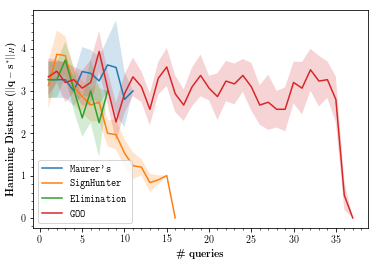

In [26]:

for is_exact in [True, False]:
    maur_agg_ham_log = []
    maur_agg_df_log = []
    elim_agg_ham_log = []
    elim_agg_df_log = []
    sign_agg_ham_log = []
    sign_agg_df_log =[]
    gray_agg_ham_log = []
    gray_agg_df_log = []



    for _ in range(30):
        np.random.seed(_)
        x = np.random.randn(n)
        searcher = ApproxHammmingSearch(lambda _: est_dir_df(x, _), n, is_exact=is_exact)
        np.random.seed(_)
        res_vec, num_queries, trace, tree_log = searcher.tree_search()
        np.random.seed(_)
        res_vec, num_queries, gray_log = searcher.gray_search()
        np.random.seed(_)
        res_vec, num_queries, _, maurer_log = searcher.maurer_search()
        res_vec, num_queries, _, elim_log = searcher.elim_search()
        

        maur_ham_log, maur_df_log = zip(*maurer_log)
        sign_ham_log, sign_df_log = zip(*tree_log)
        elim_ham_log, elim_df_log = zip(*elim_log)
        gray_ham_log, gray_df_log = zip(*gray_log)

        update_agg_log(maur_agg_ham_log, maur_ham_log)
        update_agg_log(maur_agg_df_log, maur_df_log)

        update_agg_log(sign_agg_ham_log, sign_ham_log)
        update_agg_log(sign_agg_df_log, sign_df_log)

        update_agg_log(elim_agg_ham_log, elim_ham_log)
        update_agg_log(elim_agg_df_log, elim_df_log)

        update_agg_log(gray_agg_ham_log, gray_ham_log)
        update_agg_log(gray_agg_df_log, gray_df_log)

    with warnings.catch_warnings():
        #warnings.filterwarnings('error')
        try:
            m_maur_ham = mean_agg_log(maur_agg_ham_log)
            m_maur_df = mean_agg_log(maur_agg_df_log)
            m_elim_ham = mean_agg_log(elim_agg_ham_log)
            m_elim_df = mean_agg_log(elim_agg_df_log)
            m_sign_ham = mean_agg_log(sign_agg_ham_log)
            m_sign_df = mean_agg_log(sign_agg_df_log)
            m_gray_ham = mean_agg_log(gray_agg_ham_log)
            m_gray_df = mean_agg_log(gray_agg_df_log)

            s_maur_ham = std_agg_log(maur_agg_ham_log)
            s_maur_df = std_agg_log(maur_agg_df_log)
            s_elim_ham = std_agg_log(elim_agg_ham_log)
            s_elim_df = std_agg_log(elim_agg_df_log)
            s_sign_ham = std_agg_log(sign_agg_ham_log)
            s_sign_df = std_agg_log(sign_agg_df_log)
            s_gray_ham = std_agg_log(gray_agg_ham_log)
            s_gray_df = std_agg_log(gray_agg_df_log)
            
            n_maur_ham = [len(_) for _ in maur_agg_ham_log]
            n_maur_df = [len(_) for _ in maur_agg_df_log]
            n_elim_ham = [len(_) for _ in elim_agg_ham_log]
            n_elim_df = [len(_) for _ in elim_agg_df_log]
            n_sign_ham = [len(_) for _ in sign_agg_ham_log]
            n_sign_df = [len(_) for _ in sign_agg_df_log]
            n_gray_ham = [len(_) for _ in gray_agg_ham_log]
            n_gray_df = [len(_) for _ in gray_agg_df_log]
            
            label_suffix = "dim-{}_fct-type-{}".format(n, fct_type)

            print("plotting df trace for %s Hamming oracle" % ("exact" if is_exact else "approx"))
            plot_df_trace(m_maur_df, m_sign_df, m_elim_df, m_gray_df, 
                          s_maur_df, s_sign_df, s_elim_df, s_gray_df, 
                          n_maur_df, n_sign_df, n_elim_df, n_gray_df,
                          is_exact, label_suffix)

            print("plotting Hamming trace for %s Hamming oracle" % ("exact" if is_exact else "approx"))
            plot_hd_trace(m_maur_ham, m_sign_ham, m_elim_ham, m_gray_ham, 
                          s_maur_ham, s_sign_ham, s_elim_ham, s_gray_ham, 
                          n_maur_ham, n_sign_ham, n_elim_ham, n_gray_ham,
                          is_exact, label_suffix)
        except RuntimeWarning:
            print("Exiting warning")
    
    


### Experiment 2: Performance of Maurer's Algorithm on Synthetic Toy Problem with Noisey Hamming Oracle with concentrated gradient magnitudes (Figure 4, main paper)

(a) The gradient magnitudes are concentrated to a single value (i.e., the histogram is a single bin)

In [352]:
np.random.seed(1)
## set a synthetic problem 

fct_type = 'lin'
n = 80

Q = np.eye(n) 
c = np.random.choice([0.1], n)
_eps = 1e-3

def f(x):
    """
    """
    if fct_type == 'lin':
        return c.dot(x)
    elif fct_type == 'quad':
        return x.T.dot(Q.dot(x))

def df(x):
    if fct_type == 'lin':
        return c
    elif fct_type == 'quad':
        return Q.dot(x) + Q.T.dot(x)

def est_dir_df(x, v):
    return (f(x + _eps * v) - f(x)) / _eps


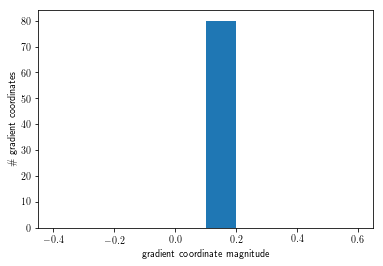

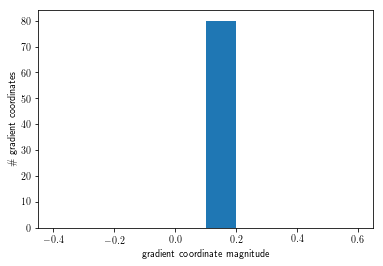

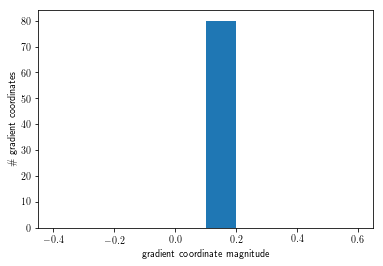

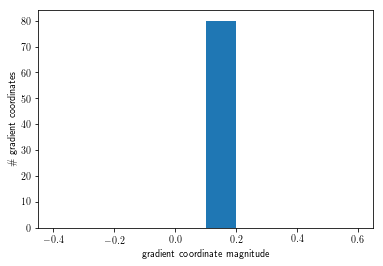

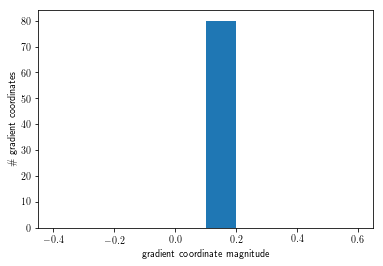

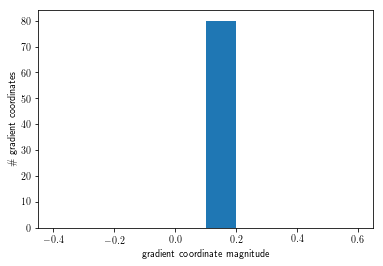

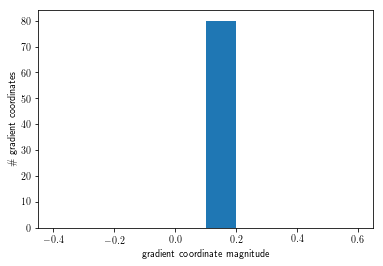

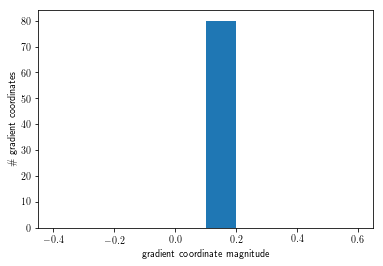

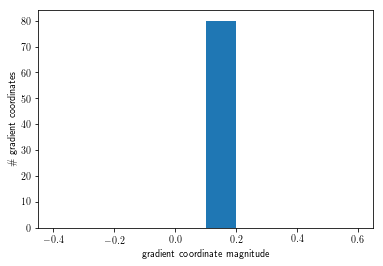

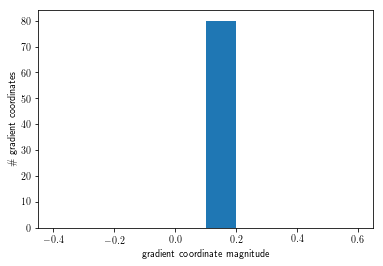

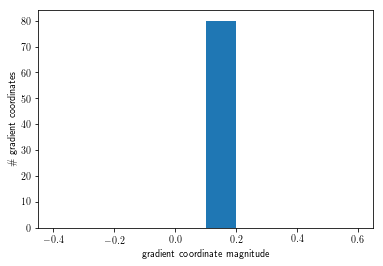

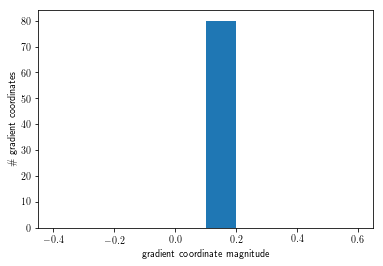

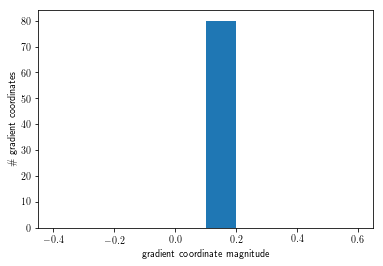

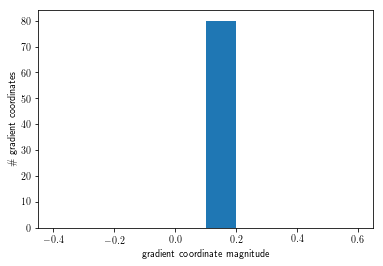

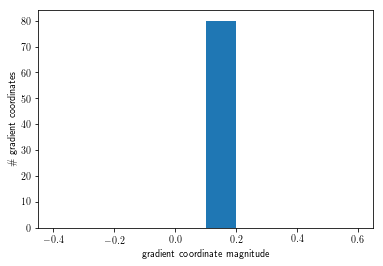

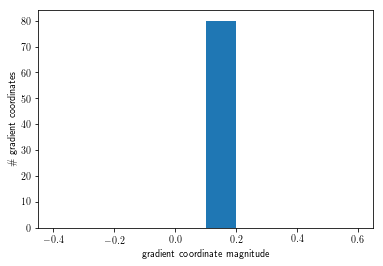

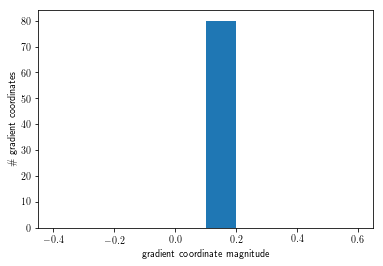

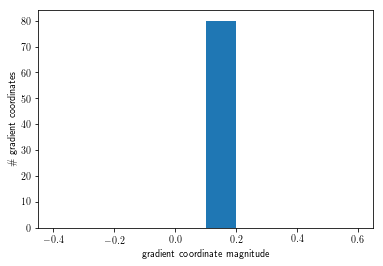

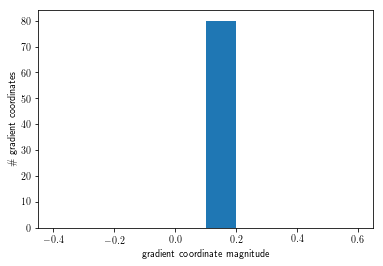

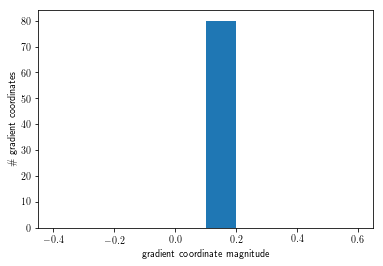

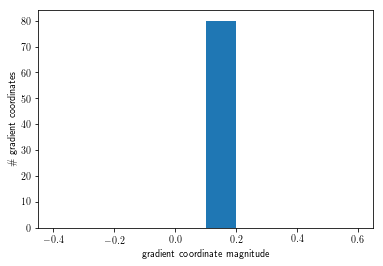

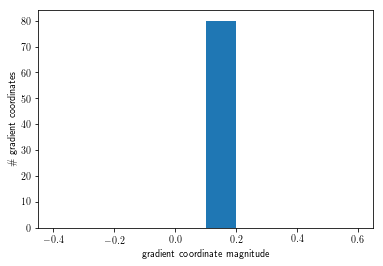

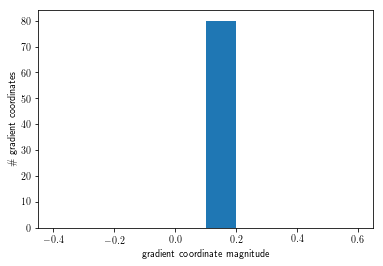

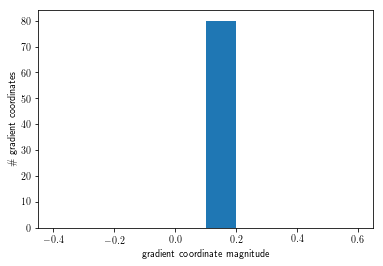

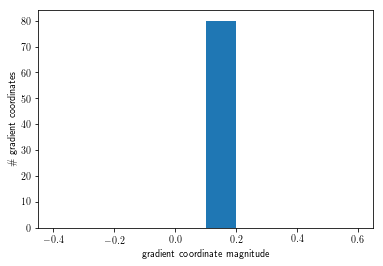

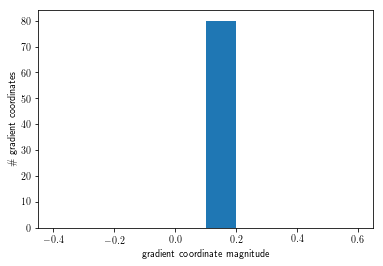

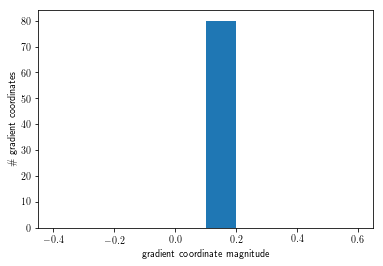

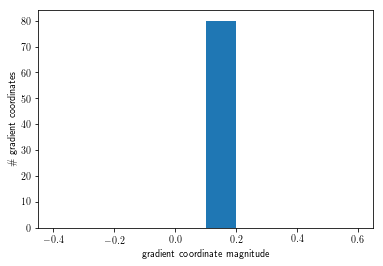

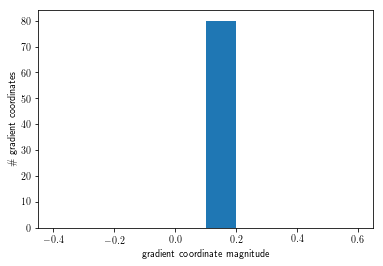

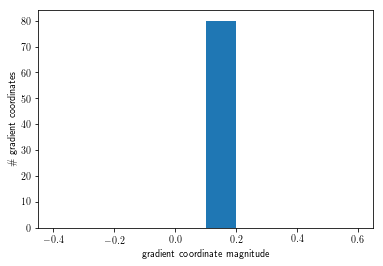

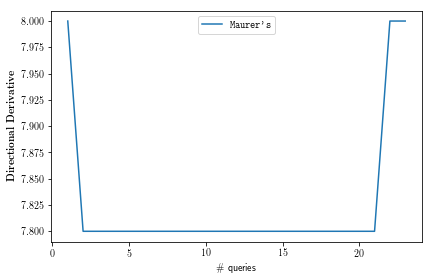

Average Hamming distance of the returned solution by Maurer's is 0.0 after 21


In [353]:
maur_agg_ham_log = []
maur_agg_df_log = []

for _ in range(30):
    x = np.random.randn(n) * 0.05
    plt.hist(abs(df(x)))
    plt.xlabel("gradient coordinate magnitude")
    plt.ylabel("\# gradient coordinates")
    plt.show()
    searcher = ApproxHammmingSearch(lambda _: est_dir_df(x, _), n, is_exact=False)
    res_vec, num_queries, _, maurer_log = searcher.maurer_search()
    maur_ham_log, maur_df_log = zip(*maurer_log)
    update_agg_log(maur_agg_ham_log, maur_ham_log)
    update_agg_log(maur_agg_df_log, maur_df_log)
    
m_maur_ham = mean_agg_log(maur_agg_ham_log)
m_maur_df = mean_agg_log(maur_agg_df_log)
s_maur_ham = std_agg_log(maur_agg_ham_log)
s_maur_df = std_agg_log(maur_agg_df_log)
n_maur_ham = [len(_) for _ in maur_agg_ham_log]
n_maur_df = [len(_) for _ in maur_agg_df_log]

plt.clf()
plot_mean(m_maur_ham, label=r'''\bf{\texttt{Maurer's}}''')
plot_conf_bounds(m_maur_ham, s_maur_ham, n_maur_ham)
plt.xlabel(r"\textbf{\large \# queries}")
plt.ylabel(r"\textbf{\large $||\mathbf{q}- \mathbf{q}^*||_H$}")
plt.legend()
#plt.show()
plt.tight_layout()
plt.savefig("maur-perf-m-1_n-{}_fct-type-{}.pdf".format(n, fct_type))

plt.clf()
plot_mean(m_maur_df, label=r'''\bf{\texttt{Maurer's}}''')
plot_conf_bounds(m_maur_df, s_maur_df, n_maur_df)
plt.ylabel(r"\bf{Directional Derivative}")
plt.xlabel(r"\# queries")
plt.legend()
plt.show()


print("Average Hamming distance of the returned solution by Maurer's is {} after {}".format(m_maur_ham[-1],
                                                                                           len(m_maur_ham)-2))

(b) The gradient magnitudes are concentrated to two values (i.e., the histogram has two bins)

In [329]:
np.random.seed(1)
## set a synthetic problem 

fct_type = 'lin'
n = 80

Q = np.eye(n) 
c = np.random.choice([0.1, 0.025], n) # np.linspace(0.1, 2/n, 2)
_eps = 1e-3

def f(x):
    """
    """
    if fct_type == 'lin':
        return c.dot(x)
    elif fct_type == 'quad':
        return x.T.dot(Q.dot(x))

def df(x):
    if fct_type == 'lin':
        return c
    elif fct_type == 'quad':
        return Q.dot(x) + Q.T.dot(x)

def est_dir_df(x, v):
    return (f(x + _eps * v) - f(x)) / _eps


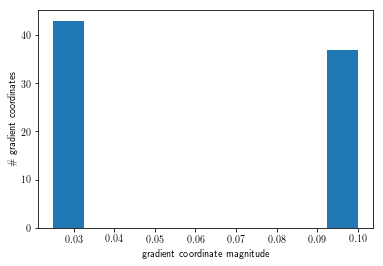

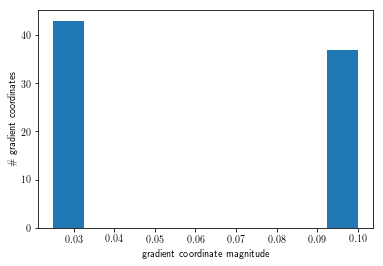

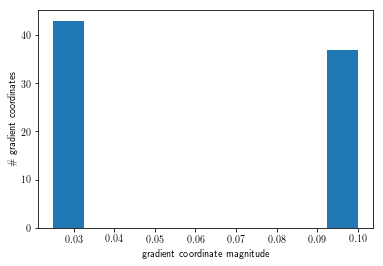

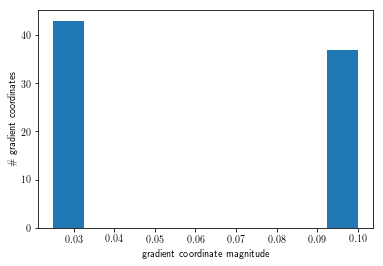

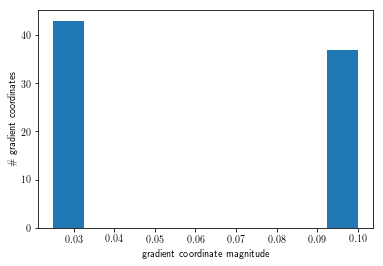

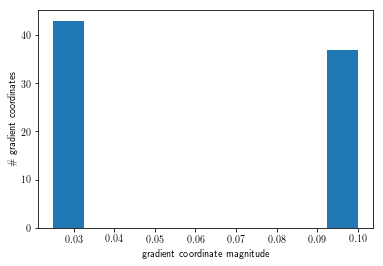

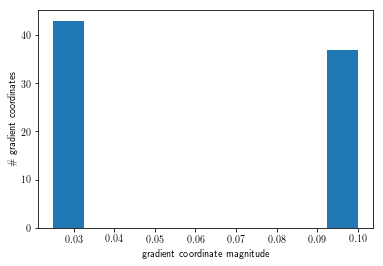

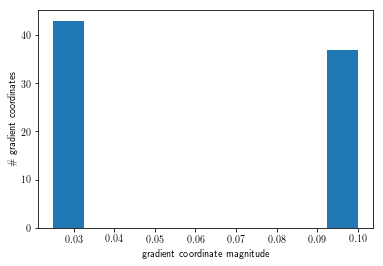

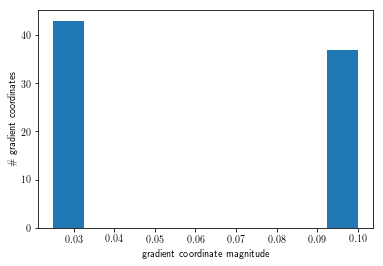

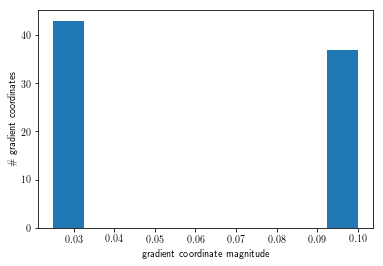

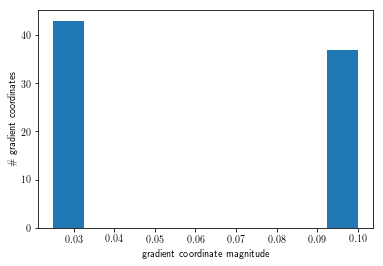

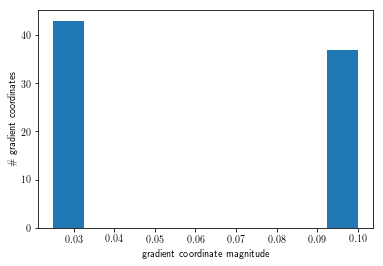

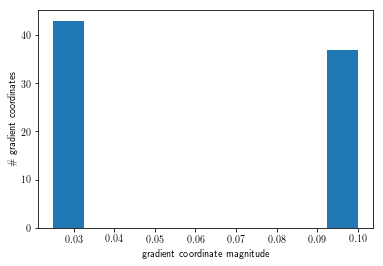

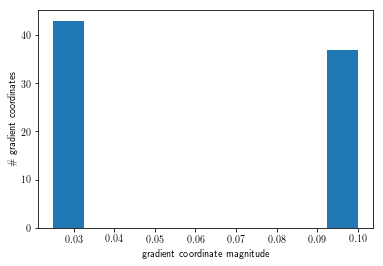

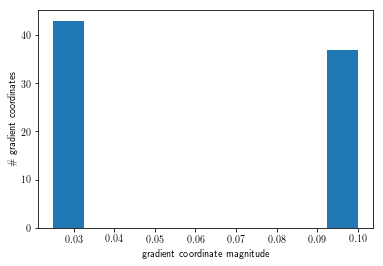

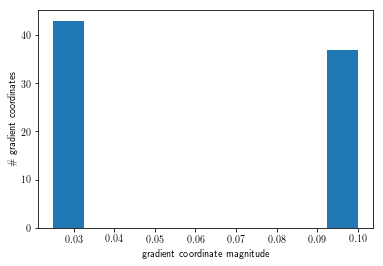

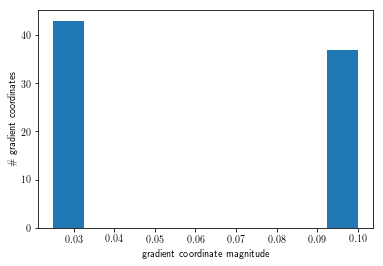

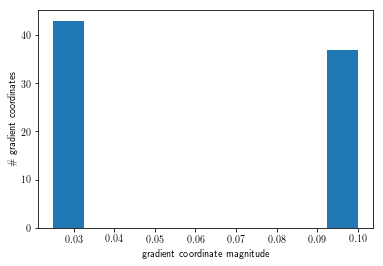

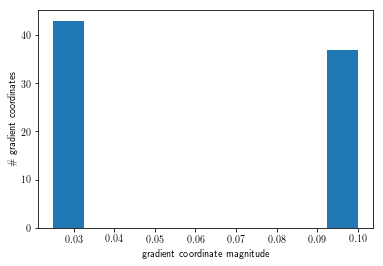

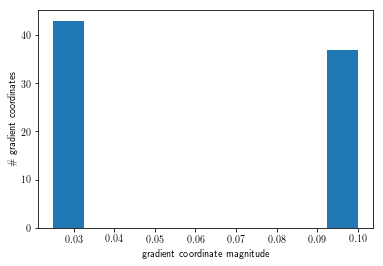

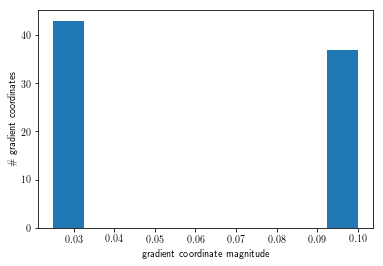

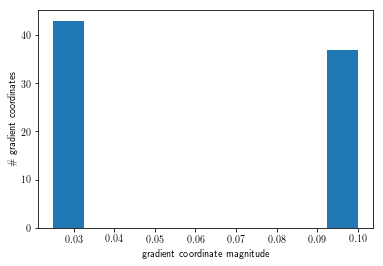

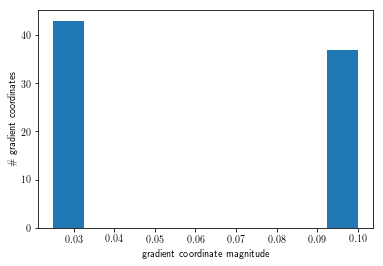

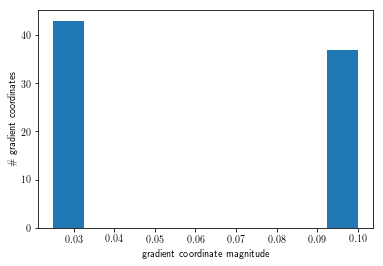

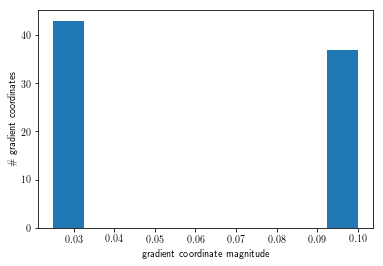

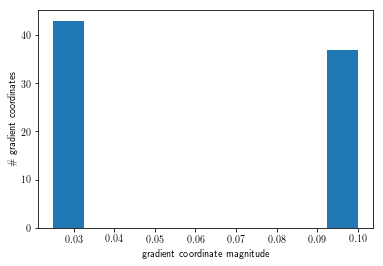

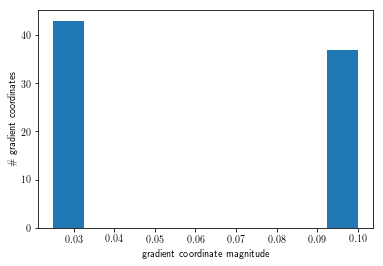

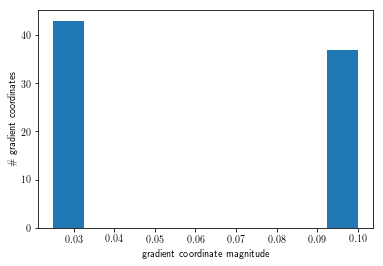

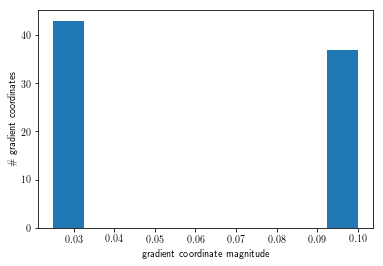

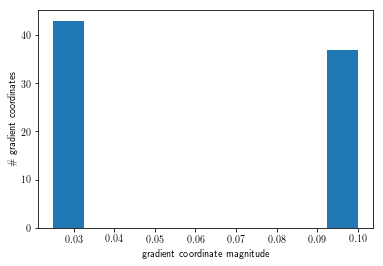

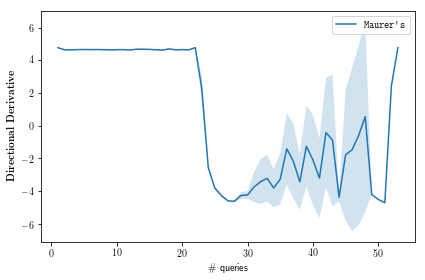

Average Hamming distance of the returned solution by Maurer's is 4.0 after 51


In [330]:
maur_agg_ham_log = []
maur_agg_df_log = []

for _ in range(30):
    x = np.random.randn(n) * 0.05
    plt.hist(abs(df(x)))
    plt.xlabel("gradient coordinate magnitude")
    plt.ylabel("\# gradient coordinates")
    plt.show()
    searcher = ApproxHammmingSearch(lambda _: est_dir_df(x, _), n, is_exact=False)
    res_vec, num_queries, _, maurer_log = searcher.maurer_search()
    maur_ham_log, maur_df_log = zip(*maurer_log)
    update_agg_log(maur_agg_ham_log, maur_ham_log)
    update_agg_log(maur_agg_df_log, maur_df_log)
    
m_maur_ham = mean_agg_log(maur_agg_ham_log)
m_maur_df = mean_agg_log(maur_agg_df_log)
s_maur_ham = std_agg_log(maur_agg_ham_log)
s_maur_df = std_agg_log(maur_agg_df_log)
n_maur_ham = [len(_) for _ in maur_agg_ham_log]
n_maur_df = [len(_) for _ in maur_agg_df_log]

plt.clf()
plot_mean(m_maur_ham, label=r'''\bf{\texttt{Maurer's}}''')
plot_conf_bounds(m_maur_ham, s_maur_ham, n_maur_ham)
plt.xlabel(r"\textbf{\large \# queries}")
plt.ylabel(r"\textbf{\large $||\mathbf{q}- \mathbf{q}^*||_H$}")
plt.legend()
#plt.show()
plt.tight_layout()
plt.savefig("maur-perf-m-2_n-{}_fct-type-{}.pdf".format(n, fct_type))

plt.clf()
plot_mean(m_maur_df, label=r'''\bf{\texttt{Maurer's}}''')
plot_conf_bounds(m_maur_df, s_maur_df, n_maur_df)
plt.ylabel(r"\bf{Directional Derivative}")
plt.xlabel(r"\# queries")
plt.legend()
plt.show()

print("Average Hamming distance of the returned solution by Maurer's is {} after {}".format(m_maur_ham[-1],
                                                                                           len(m_maur_ham)-2))

### Experiment 3: Local Smoothness of Directional Derivative for Gray-code Optimistic Optimization (GOO) (Figure 8, Supplement)

In [121]:
np.random.seed(1)
## set a synthetic problem 

# change these to {'lin', quad'} x {3, 4}
fct_type = 'lin'
n = 3

#Q = np.eye(n) #
Q = np.random.randn(n,n)
c = np.random.randn(n)
_eps = 1e-3

def f(x):
    """
    """
    if fct_type == 'lin':
        return c.dot(x)
    elif fct_type == 'quad':
        return x.T.dot(Q.dot(x))

def df(x):
    if fct_type == 'lin':
        return c
    elif fct_type == 'quad':
        return Q.dot(x) + Q.T.dot(x)

def est_dir_df(x, v):
    return (f(x + _eps * v) - f(x)) / _eps


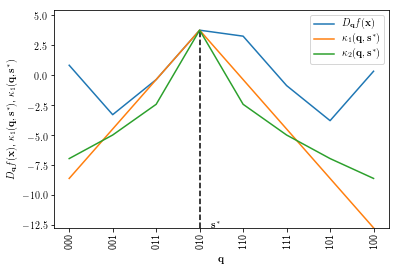

In [122]:
_x = np.random.randn(n) 
opt_x = np.sign(df(_x))
fct = lambda _: df(_x).dot(_)
xs = [get_gray_code(j, n=n, is_array=True) for j in range(2**n)]
fs = [fct(x) for x in xs]
h_dists = [hamming_dist(opt_x, x) for x in xs]
f_opt = np.max(fs)
idx_opt = np.argmax(fs)
C_l = max(abs(df(_x))) * 2
ls = [f_opt - C_l * abs(idx - idx_opt) for idx in range(2**n)]
ls2 = [f_opt - 1.5 * C_l * abs(idx - idx_opt)**0.5 for idx in range(2**n)]

plt.vlines(x=idx_opt, ymin=min(ls), ymax=f_opt, linestyle='--')
plt.text(idx_opt+ 0.25, min(ls), r"$\mathbf{s}^*$")
plt.plot(fs, label='$D_{\mathbf{q}}f(\mathbf{x})$')
plt.plot(ls, label='$\kappa_1(\mathbf{q}, \mathbf{s}^*)$')
plt.plot(ls2, label='$\kappa_2(\mathbf{q}, \mathbf{s}^*)$')
plt.xlabel(r'$\mathbf{q}$')
plt.ylim(min(ls), f_opt + 0.1 * (f_opt - min(ls))) 
plt.ylabel(r"$D_{\mathbf{q}}f(\mathbf{x})$, $\kappa_1(\mathbf{q}, \mathbf{s}^*)$, $\kappa_1(\mathbf{q}, \mathbf{s}^*)$")
plt.xticks(np.arange(2**n), [get_gray_code(j, n) for j in range(2**n)], rotation=90)
#plt.plot(h_dists, label='h_dist')
_ = plt.legend(loc='upper right')
plt.savefig("goo_smoothness_type-{}_dim-{}.pdf".format(fct_type, n))

### Experiment 4: Visualize the GOO tree (Figure 9, supplement)

Figure will be saved as PNG in the same directory of this notebook

In [341]:
n = 5
max_fevals = 100
fct= lambda _:  np.ones(n).dot(_)
tree = gray_oo(n, max_fevals, fct, is_dot_file=True)

Tree is exhausted, exiting!


In [346]:
# Print the gray-code ordering
for j in range(2**n):
    print(get_gray_code(j, n))
    print()

00000

00001

00011

00010

00110

00111

00101

00100

01100

01101

01111

01110

01010

01011

01001

01000

11000

11001

11011

11010

11110

11111

11101

11100

10100

10101

10111

10110

10010

10011

10001

10000



### Experiment 5: Quality of Noisy Hamming Oracle: as a function of the gradient coordinate magnitude concentration (Fig 3, Main Paper)


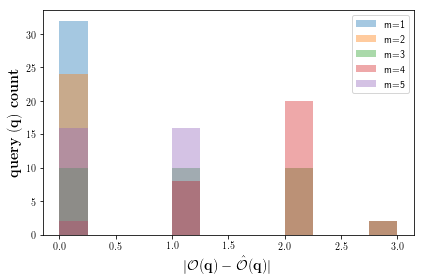

In [348]:
np.random.seed(1)
## set a synthetic problem 

# change these to {'lin'} x {10, 5}
fct_type = 'lin'
n = 5

err_dist = []

for m in range(1, n+1):
    c = np.random.choice(np.linspace(0.1, m / n, m), n)
    _eps = 1e-3

    def f(x):
        """
        """
        if fct_type == 'lin':
            return c.dot(x)
        elif fct_type == 'quad':
            return x.T.dot(Q.dot(x))

    def df(x):
        if fct_type == 'lin':
            return c
        elif fct_type == 'quad':
            return Q.dot(x) + Q.T.dot(x)

    def est_dir_df(x, v):
        return (f(x + _eps * v) - f(x)) / _eps
    
    x = np.random.randn(n)
    exact_searcher = ApproxHammmingSearch(lambda _: df(x).dot(_), n, is_exact=True)
    approx_searcher = ApproxHammmingSearch(lambda _: df(x).dot(_), n, is_exact=False)
    
    errs = []
    for j in range(2**n):
        _v = get_gray_code(j, n,is_array=True)
        est_hd = approx_searcher._df_hamming_oracle(_v,is_hamming=True)
        true_hd = exact_searcher._df_hamming_oracle(_v, is_hamming=True)
        #print(est_hd, true_hd)
        errs.append(abs(est_hd - true_hd))
    err_dist.append(errs)
    
bins=np.histogram(np.hstack(err_dist), bins=12)[1] #get the bin edges
for m, errs in enumerate(err_dist):
    plt.hist(errs,label='m={}'.format(m+1), alpha=0.4, bins=bins)
    plt.xlabel(r'\Large \bf{$|\mathcal{O}(\mathbf{q}) - \hat{\mathcal{O}}(\mathbf{q})|$}')
    _ = plt.ylabel(r'\Large \bf{query $(\mathbf{q})$ count}')
_ = plt.legend()
_ = plt.tight_layout()
plt.savefig("hd_est_erro_n-{}_fct-type-{}.pdf".format(n, fct_type))
